#### 필요 패키지
- folium
- lxml
- geopandas 및 의존성 패키지들(https://thlee33.medium.com/windows-10%EC%97%90%EC%84%9C-geopandas-%EC%84%A4%EC%B9%98%ED%95%98%EA%B8%B0-2021-07-f07efea9294a)

---

In [82]:
import folium

location = [37.2410864, 127.1775537]

def getNewMap():
  return folium.Map(location = location, tiles='cartodbpositron', zoom_start=11)

### 행정동 지도

In [83]:
# geojson 형식의 파일을 dataframe으로 만들고 'adm_nm' 컬럼에 문자열 '용인시'를 포함하는 행만 추출

import geopandas as gpd

df = gpd.read_file('../data/dataset/행정동.geojson', encoding ='utf-8')
df = df[df['adm_nm'].str.contains('용인시')]
df.head()

OBJECTID          adm_nm   adm_cd     adm_cd2    sgg sido sidonm  \
1464      1484  경기도 용인시처인구 포곡읍  3119111  4146125000  41461   41    경기도   
1465      1485  경기도 용인시처인구 모현읍  3119112  4146125300  41461   41    경기도   
1466      1486  경기도 용인시처인구 남사읍  3119114  4146125900  41461   41    경기도   
1467      1487  경기도 용인시처인구 이동읍  3119113  4146125600  41461   41    경기도   
1468      1488  경기도 용인시처인구 원삼면  3119134  4146134000  41461   41    경기도   

       sggnm   adm_cd8                                           geometry  
1464  용인시처인구  31191110  MULTIPOLYGON (((127.27860 37.30544, 127.28042 ...  
1465  용인시처인구  31191120  MULTIPOLYGON (((127.28334 37.34531, 127.28316 ...  
1466  용인시처인구  31191140  MULTIPOLYGON (((127.18870 37.08636, 127.18623 ...  
1467  용인시처인구  31191130  MULTIPOLYGON (((127.17441 37.22459, 127.17541 ...  
1468  용인시처인구  31191340  MULTIPOLYGON (((127.34840 37.20436, 127.34731 ...

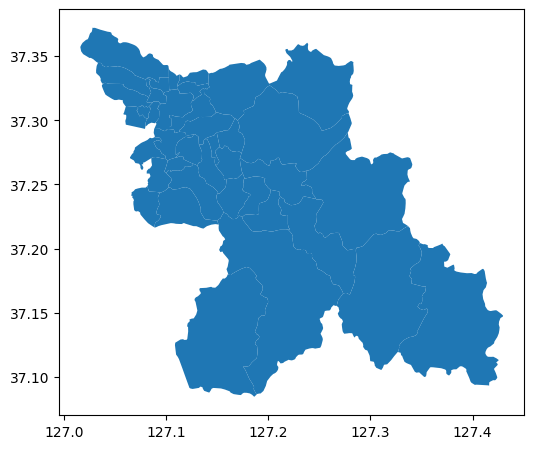

In [84]:
import matplotlib.pyplot as plt

df.plot(figsize=(6, 6))
plt.show()

In [85]:
def draw_yongin_on_map(m):
  for _, r in df.iterrows():
    simplifed_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance = 0.001)
    geo = simplifed_geo.to_json()
    geo = folium.GeoJson(data = geo, style_function= lambda x: {'fillColor' : 'orange', 'color': 'black'})
    folium.Popup(r['adm_nm']).add_to(geo)
    geo.add_to(m)
    

### 전기 충전소 지도

In [160]:
import pandas as pd
# station_df = pd.read_xml('../data/dataset/전기충전소정보.xml', encoding='UTF-8')
station_df = pd.read_csv('../data/dataset/기존충전소위경도정보.csv', index_col = 0)

In [173]:
station_df

이름         위도          경도
0              신동백 두산위브더제니스  37.306879  127.130787
1                   죽전역 솔하임  37.328545  127.114735
2                  광교상현 솔하임  37.302515  127.074668
3     성복역 롯데캐슬 클라시엘(파크나인2차)  37.319601  127.061733
4                   까뮤이스테이트  37.335116  127.109361
...                     ...        ...         ...
1256                  나인무인텔  37.208291  127.320402
1257                     명가  37.277380  127.232383
1258            금화마을대우현대아파트  37.264701  127.110847
1259           플랫폼시티아이브오피스텔  37.298363  127.110283
1260     삼천리 에버랜드 복합충전소(완속)  37.293272  127.222609

[1261 rows x 3 columns]

In [171]:
station_map = getNewMap()
draw_yongin_on_map(station_map)
station_map

In [172]:
positions = station_df[['위도', '경도']].values.tolist()

for position in positions:
      folium.Circle(position, radius= 100, color='#218721', fill=True).add_to(station_map)
      
station_map


In [90]:
station_map.save('../map/station.html')

### 수요 지도

## TODO
- resident, activity 구분한 수요 지도도 그리기

In [92]:
import pandas as pd

resident_demand_df = pd.read_csv('../data/dataset/1.ev_app_resident.csv')
activity_demand_df = pd.read_csv('../data/dataset/2.ev_app_activity.csv')
total_demand_df = pd.read_csv('../data/dataset/4.ev_resident+ev_activity+ev_activity_resident.csv')

In [93]:
# TODO 행정동 geo data에 합쳐서 지도에 수요 나타내기 -> Chropleth 맵 그리기
resident_demand_df = resident_demand_df[['adng_nm','cell_id', 'cell_xcrd', 'cell_ycrd', 'count_cust']]
activity_demand_df = activity_demand_df[['adng_nm','cell_id', 'cell_xcrd', 'cell_ycrd', 'count_cust']]
total_demand_df = total_demand_df[['adng_nm','cell_id', 'cell_xcrd', 'cell_ycrd', 'count_cust']]

In [94]:
# 지역명으로 그룹화 후 수요를 합해 새로운 데이터프레임 생성

resident_demand_df = resident_demand_df.groupby('adng_nm')['count_cust'].sum().to_frame().reset_index()
activity_demand_df = activity_demand_df.groupby('adng_nm')['count_cust'].sum().to_frame().reset_index()
total_demand_df = total_demand_df.groupby('adng_nm')['count_cust'].sum().to_frame().reset_index()

In [95]:
# 수요 데이터와 매핑하기 위해서 지리 데이터의 지역명 중 읍, 동만 남김

anm_nm = df['adm_nm'].apply(lambda x : x.split()[2])
df['adm_nm'] = anm_nm

In [96]:
df.head()

OBJECTID adm_nm   adm_cd     adm_cd2    sgg sido sidonm   sggnm  \
1464      1484    포곡읍  3119111  4146125000  41461   41    경기도  용인시처인구   
1465      1485    모현읍  3119112  4146125300  41461   41    경기도  용인시처인구   
1466      1486    남사읍  3119114  4146125900  41461   41    경기도  용인시처인구   
1467      1487    이동읍  3119113  4146125600  41461   41    경기도  용인시처인구   
1468      1488    원삼면  3119134  4146134000  41461   41    경기도  용인시처인구   

       adm_cd8                                           geometry  
1464  31191110  MULTIPOLYGON (((127.27860 37.30544, 127.28042 ...  
1465  31191120  MULTIPOLYGON (((127.28334 37.34531, 127.28316 ...  
1466  31191140  MULTIPOLYGON (((127.18870 37.08636, 127.18623 ...  
1467  31191130  MULTIPOLYGON (((127.17441 37.22459, 127.17541 ...  
1468  31191340  MULTIPOLYGON (((127.34840 37.20436, 127.34731 ...

In [97]:
def draw_demand_map(data_df):
  m = getNewMap()
  
  folium.Choropleth(
    geo_data = df,
    data = data_df,
    columns = ('adng_nm', 'count_cust'),
    key_on = "feature.properties.adm_nm",
    fill_color = "OrRd",
    legend_name = "지역별 수요",
  ).add_to(m)
  
  return m

In [98]:
# 검은 색으로 나타나는 구역은 수요 정보가 없는 곳으로 추정

resdient_demand_map = draw_demand_map(resident_demand_df)
activity_demand_map = draw_demand_map(activity_demand_df)
total_demand_map = draw_demand_map(total_demand_df)

In [99]:
resdient_demand_map

In [100]:
activity_demand_map

In [101]:
total_demand_map

In [138]:
result_df = pd.read_csv('../data/dataset/7.fin_location.csv', index_col=0)

In [139]:
# 모든 후보군

candidate_map = getNewMap()
draw_yongin_on_map(candidate_map)

for i, r in result_df.iterrows():
  folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#0072B2', fill=True).add_to(candidate_map)

folium.LayerControl().add_to(candidate_map)
candidate_map

In [140]:
# 빨간색: 기존 충전소가 1km 반경 내에 설치되어 있는 후보군
# 파란색: 1km 반경 내에 충전소가 설치되어있지 않은 후보군

result_map = getNewMap()
draw_yongin_on_map(result_map)

for i, r in result_df.iterrows():
  # 1km 내에 존재하는 경우. 빨간색
  if r['existing']:
    folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#D95F02', fill=True).add_to(result_map)
  else:
    folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#0072B2', fill=True).add_to(result_map)
  
folium.LayerControl().add_to(result_map)
result_map

In [141]:
result_df = result_df[result_df['existing'] == 0]
result_map = getNewMap()
draw_yongin_on_map(result_map)

for i, r in result_df.iterrows():
    folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#0072B2').add_to(result_map)

folium.LayerControl().add_to(result_map)
result_map


In [142]:
result_df

cluster_이름       xcrds      ycrds  existing  demand_satisfied
0         1001  127.295784  37.188830         0                 0
1         1013  127.223315  37.135049         0                 0
2         1014  127.213345  37.315307         0                 0
3         1017  127.227875  37.354329         0                 1
4        10206  127.419215  37.135348         0                 0
..         ...         ...        ...       ...               ...
903        963  127.368197  37.177893         0                 1
904        974  127.367468  37.111187         0                 0
905        976  127.222549  37.190262         0                 0
906         99  127.252040  37.302776         0                 1
907        997  127.317470  37.192700         0                 1

[908 rows x 5 columns]

In [143]:
result_map = getNewMap()
draw_yongin_on_map(result_map)

removed = 0

for i, r in result_df.iterrows():
  # 수요 15회를 만족하는 충전소
  if r['demand_satisfied']:
    folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#0072B2', fill=True).add_to(result_map)
  else:
    removed += 1
    folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#D63E2A', fill=True).add_to(result_map)
    

folium.LayerControl().add_to(result_map)
result_map


In [119]:
# 수요 62.5개 미만을 맡는 충전소
print(removed)

311


In [149]:
result_df = result_df[result_df['demand_satisfied'] == 1]

result_map = getNewMap()
draw_yongin_on_map(result_map)

for i, r in result_df.iterrows():
    folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#0072B2', fill=True).add_to(result_map)
    

folium.LayerControl().add_to(result_map)
result_map

In [169]:
from folium.plugins import BeautifyIcon

square_icon = BeautifyIcon(
    icon_shape='rectangle-dot', 
    border_color='red', 
    border_width=10,
)

result_map = getNewMap()
draw_yongin_on_map(result_map)

for i, r in result_df.iterrows():
  folium.Circle([r['ycrds'], r['xcrds']], radius= 100, color='#0072B2', fill=True).add_to(result_map)

for position in positions:
  folium.Circle(position, radius= 100, color='#218721', fill=True).add_to(result_map)
  
result_map